In [1]:
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import glob
import scipy
import re
import random
import time
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import ttest_ind
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import KFold

from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.optimize import minimize
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.3f}".format

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 9
cm = 1/2.54
fig_folder = './Figure_3_exports'
data_folder = './Figure_3_data'

# Neural network training and evaluation

## Read in data

In [3]:
data = pd.read_pickle('../General_data/screen_active_data.pkl')
data

,experiment_id,day,plate,well_name,Supp,DNA_name,DNA_conc,Liposome_name,Liposome_conc,Mg,SecYE,K,WCE,PEG,pmol,rxn_id,label
0,eCM313,1.000,1.000,H12,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,4.918,0.000,screen
1,eCM313,1.000,1.000,K12,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,4.311,0.000,screen
2,eCM313,1.000,1.000,M5,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,2.644,0.000,screen
3,eCM313,2.000,4.000,J2,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,7.546,0.000,screen
4,eCM313,2.000,4.000,N22,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,7.527,0.000,screen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33542,eCM313,2.000,3.000,A1,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.149,3966.000,screen
33543,eCM313,2.000,4.000,B2,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.265,3862.000,screen
33544,eCM313,2.000,4.000,B2,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.265,3966.000,screen
33545,eCM313,2.000,4.000,G6,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,2.024,3862.000,screen


In [4]:
data.value_counts('experiment_id')

experiment_id
eCM331    2865
eCM316    2303
eCM313    1721
eCM336    1693
eCM314    1376
eCM317    1239
Name: count, dtype: int64

In [5]:
sub_df = []

for rxn_id,rxn_df in data.groupby('rxn_id'):
    lipo = rxn_df[rxn_df['Liposome_conc'] != 0].copy()
    nolipo = rxn_df[rxn_df['Liposome_conc'] == 0].copy()
    nolipo_mean = np.mean(nolipo['pmol'])
    if len(nolipo) == 0:
        print(rxn_id)
        continue
    lipo['pmol_sub'] = lipo['pmol'] - nolipo_mean
    nolipo['pmol_sub'] = nolipo['pmol'] - nolipo_mean
    
    sub_df.append(lipo)
    sub_df.append(nolipo)
    
sub_df = pd.concat(sub_df)
sub_df

,experiment_id,day,plate,well_name,Supp,DNA_name,DNA_conc,Liposome_name,Liposome_conc,Mg,SecYE,K,WCE,PEG,pmol,rxn_id,label,pmol_sub
0,eCM313,1.000,1.000,H12,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,4.918,0.000,screen,2.688
1,eCM313,1.000,1.000,K12,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,4.311,0.000,screen,2.081
2,eCM313,1.000,1.000,M5,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,2.644,0.000,screen,0.414
3,eCM313,2.000,4.000,J2,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,7.546,0.000,screen,5.316
4,eCM313,2.000,4.000,N22,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,7.527,0.000,screen,5.297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33538,eCM313,1.000,2.000,C22,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.915,3966.000,screen,0.238
33540,eCM313,1.000,2.000,N11,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.529,3966.000,screen,-0.148
33542,eCM313,2.000,3.000,A1,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.149,3966.000,screen,-0.529
33544,eCM313,2.000,4.000,B2,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.265,3966.000,screen,-0.413


### Organize all reaction variables and convert the categorical variables

In [6]:
training_data = sub_df.copy()
# training_data = training_data[training_data['label'] == 'screen'].copy()
training_data = training_data[training_data['Liposome_name'] != 'no_lipo'].copy()


lipo_dict = {'DOPC':18,'DPPC':16,'DMPC':14,'no_lipo':0}

training_data['lipid'] = training_data['Liposome_name'].apply(lambda x: lipo_dict[x])
training_data = training_data[['rxn_id','DNA_name','lipid','Mg','SecYE','K','PEG','pmol','pmol_sub']].copy()
training_data

,rxn_id,DNA_name,lipid,Mg,SecYE,K,PEG,pmol,pmol_sub
0,0.000,AqpZ,14,8.000,0.000,85,2.000,4.918,2.688
1,0.000,AqpZ,14,8.000,0.000,85,2.000,4.311,2.081
2,0.000,AqpZ,14,8.000,0.000,85,2.000,2.644,0.414
3,0.000,AqpZ,14,8.000,0.000,85,2.000,7.546,5.316
4,0.000,AqpZ,14,8.000,0.000,85,2.000,7.527,5.297
...,...,...,...,...,...,...,...,...,...
15746,3966.000,Vol,18,20.000,1.250,135,2.000,1.240,-0.438
15747,3966.000,Vol,18,20.000,1.250,135,2.000,1.230,-0.447
15748,3966.000,Vol,18,20.000,1.250,135,2.000,1.726,0.048
15749,3966.000,Vol,18,20.000,1.250,135,2.000,1.145,-0.532


### Convert the protein names into unique columns for each protein using OneHot encoding

In [7]:
def add_one_hot(df,col_name):
    temp = df[[col_name]]

    one_hot_encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoder.fit(temp)

    encoded = one_hot_encoder.transform(temp)
    encoded = pd.DataFrame(data=encoded, columns=[col_name+'-'+c for c in one_hot_encoder.categories_])
    df = df.join(encoded)
    targets = list([col_name+'-'+c for c in one_hot_encoder.categories_])[0]
    original = [(t,) for t in targets]
    df = df.rename(columns=dict(zip(original,targets)))
    return df


prot_feat = training_data[['DNA_name']].drop_duplicates().reset_index(drop=True)
dna_encoded = add_one_hot(prot_feat,'DNA_name')

dna_encoded.columns

Index(['DNA_name', 'DNA_name-AqpZ', 'DNA_name-Aux', 'DNA_name-B2AR',
       'DNA_name-B3AR', 'DNA_name-Beta', 'DNA_name-CD47', 'DNA_name-CD63',
       'DNA_name-CD81', 'DNA_name-CD9', 'DNA_name-CML1', 'DNA_name-CRCM',
       'DNA_name-CaM', 'DNA_name-Cx43', 'DNA_name-Dia', 'DNA_name-FFAR4',
       'DNA_name-Glut', 'DNA_name-InP', 'DNA_name-Mito', 'DNA_name-Mol',
       'DNA_name-MscL', 'DNA_name-MtlA', 'DNA_name-Neu', 'DNA_name-OR1A1',
       'DNA_name-OR1D2', 'DNA_name-OR1E1', 'DNA_name-OR2AG1',
       'DNA_name-SecYE-G', 'DNA_name-Vol'],
      dtype='object')

In [8]:
all_features = training_data.set_index('DNA_name').join(dna_encoded.set_index('DNA_name')).reset_index()
all_features

,DNA_name,rxn_id,lipid,Mg,SecYE,K,PEG,pmol,pmol_sub,DNA_name-AqpZ,...,DNA_name-Mol,DNA_name-MscL,DNA_name-MtlA,DNA_name-Neu,DNA_name-OR1A1,DNA_name-OR1D2,DNA_name-OR1E1,DNA_name-OR2AG1,DNA_name-SecYE-G,DNA_name-Vol
0,AqpZ,0.000,14,8.000,0.000,85,2.000,4.918,2.688,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,AqpZ,0.000,14,8.000,0.000,85,2.000,4.311,2.081,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,AqpZ,0.000,14,8.000,0.000,85,2.000,2.644,0.414,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,AqpZ,0.000,14,8.000,0.000,85,2.000,7.546,5.316,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,AqpZ,0.000,14,8.000,0.000,85,2.000,7.527,5.297,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,Vol,3966.000,18,20.000,1.250,135,2.000,1.240,-0.438,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
5502,Vol,3966.000,18,20.000,1.250,135,2.000,1.230,-0.447,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
5503,Vol,3966.000,18,20.000,1.250,135,2.000,1.726,0.048,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
5504,Vol,3966.000,18,20.000,1.250,135,2.000,1.145,-0.532,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


### Min-Max scaling reaction condition variables

In [9]:
data_bounded = all_features[['Mg', 'SecYE', 'K', 'PEG','lipid']]
X_bounded = np.array(data_bounded)
MMscalerX = MinMaxScaler()
X_bounded = MMscalerX.fit_transform(X_bounded)
data_bounded = pd.DataFrame(X_bounded,columns=data_bounded.columns)
data_bounded['rxn_id'] = all_features['rxn_id']
data_bounded = data_bounded.drop_duplicates().set_index('rxn_id')
data_bounded

,Mg,SecYE,K,PEG,lipid
rxn_id,,,,,
0.000,0.000,0.000,0.000,1.000,0.000
1.000,0.000,0.000,0.000,0.000,0.000
2.000,0.000,0.000,0.000,1.000,0.000
3.000,0.000,0.000,0.500,1.000,0.000
4.000,0.000,0.000,0.500,0.000,0.000
...,...,...,...,...,...
3953.000,1.000,0.000,0.500,1.000,1.000
3954.000,1.000,0.000,1.000,0.000,1.000
3964.000,1.000,0.500,1.000,0.000,1.000


### Standard Scaling
* Calculates the z-scored values for each protein to capture the relative impact of reaction conditions on each protein rather than the overall yield of the protein.
* Normalizes both the raw pmol value and the no liposome subtracted out pmol values
* All final models, however, use the raw pmol values for training

In [10]:
y_col = 'pmol'

transformed = []
scaler_dict = {}

for dna, dna_df in all_features.groupby('DNA_name'):
    temp = dna_df.copy()
    y_scaled = np.array(dna_df[[y_col]])
    scalerY = StandardScaler()
    y_scaled = scalerY.fit_transform(y_scaled)
    temp['label'] = y_scaled
    transformed.append(temp)
    scaler_dict.update({dna:scalerY})
transformed = pd.concat(transformed)
transformed = transformed[['rxn_id','label']].set_index('rxn_id')
transformed

,label
rxn_id,
0.000,-0.570
0.000,-0.656
0.000,-0.891
0.000,-0.201
0.000,-0.203
...,...
3966.000,-0.656
3966.000,-0.665
3966.000,-0.194


In [11]:
y_col = 'pmol_sub'

transformed_sub = []
scaler_dict_sub = {}

for dna, dna_df in all_features.groupby('DNA_name'):
    temp = dna_df.copy()
    y_scaled = np.array(dna_df[[y_col]])
    scalerY = StandardScaler()
    y_scaled = scalerY.fit_transform(y_scaled)
    temp['label_sub'] = y_scaled
    transformed_sub.append(temp)
    scaler_dict_sub.update({dna:scalerY})
transformed_sub = pd.concat(transformed_sub)
transformed_sub = transformed_sub[['rxn_id','label_sub']].set_index('rxn_id')
transformed_sub['label'] = transformed['label']
transformed_sub

,label_sub,label
rxn_id,,
0.000,-0.566,-0.570
0.000,-0.666,-0.656
0.000,-0.941,-0.891
0.000,-0.133,-0.201
0.000,-0.136,-0.203
...,...,...
3966.000,-0.104,-0.656
3966.000,-0.122,-0.665
3966.000,0.793,-0.194


In [12]:
encoded_cols = [c for c in all_features.columns if '-' in c]
encoded_cols = all_features[encoded_cols+['rxn_id','DNA_name']].drop_duplicates().set_index('rxn_id')
encoded_cols

,DNA_name-AqpZ,DNA_name-Aux,DNA_name-B2AR,DNA_name-B3AR,DNA_name-Beta,DNA_name-CD47,DNA_name-CD63,DNA_name-CD81,DNA_name-CD9,DNA_name-CML1,...,DNA_name-MscL,DNA_name-MtlA,DNA_name-Neu,DNA_name-OR1A1,DNA_name-OR1D2,DNA_name-OR1E1,DNA_name-OR2AG1,DNA_name-SecYE-G,DNA_name-Vol,DNA_name
rxn_id,,,,,,,,,,,,,,,,,,,,,
0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
3.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
4.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,Vol
3954.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,Vol
3964.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,Vol


In [13]:
norm_data = transformed_sub.join(data_bounded).join(encoded_cols).reset_index()
norm_data

,rxn_id,label_sub,label,Mg,SecYE,K,PEG,lipid,DNA_name-AqpZ,DNA_name-Aux,...,DNA_name-MscL,DNA_name-MtlA,DNA_name-Neu,DNA_name-OR1A1,DNA_name-OR1D2,DNA_name-OR1E1,DNA_name-OR2AG1,DNA_name-SecYE-G,DNA_name-Vol,DNA_name
0,0.000,-0.566,-0.570,0.000,0.000,0.000,1.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
1,0.000,-0.666,-0.656,0.000,0.000,0.000,1.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
2,0.000,-0.941,-0.891,0.000,0.000,0.000,1.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
3,0.000,-0.133,-0.201,0.000,0.000,0.000,1.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
4,0.000,-0.136,-0.203,0.000,0.000,0.000,1.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,3966.000,-0.104,-0.656,1.000,1.000,0.500,1.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,Vol
5502,3966.000,-0.122,-0.665,1.000,1.000,0.500,1.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,Vol
5503,3966.000,0.793,-0.194,1.000,1.000,0.500,1.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,Vol
5504,3966.000,-0.279,-0.745,1.000,1.000,0.500,1.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,Vol


### Design feature sets for ensembles
* Here is where the features included in the input layer of the neural network are set. 
* Any modification to the inputs are defined as new ensembles and all the column names for the included data need to be combined as a single list
* This could include protein metadata like their length, organism of origin, etc. 

In [14]:
rxn_features = ['Mg','SecYE','K','PEG','lipid']
dna_features = [c for c in norm_data.columns if 'DNA_name-' in c]


In [15]:
col_dict = {
    'dna_encoded':rxn_features+dna_features,
}

### Specification of the model architecture
* The neural network implemented here is a simple sequential neural network
* The input layer is dynamically generated to match the input data
* The other layers are Densely connected layers which are defined by a number of node and an activation function
* The make_model function takes in a list of nodes that will be used to define all the hidden layers
* All models have a single node output layer that uses a linear activation function
* All models also use Adam optimization method

In [16]:
def make_model(learning_rate=1e-3,nodes=[256,128,64,32,16],loss='mean_absolute_error'):
    temp = [tf.keras.layers.Dense(n, activation='relu') for n in nodes] + [tf.keras.layers.Dense(1, activation="linear")]
    model = tf.keras.Sequential([*temp])
    
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    return model

def prep_data(train,test,target='label'):
    to_drop = 'rxn_id'
    train = train.drop(columns=to_drop)
    test = test.drop(columns=to_drop)
    
    cols = [col for col in train.columns.values if col not in ['label','label_sub']]
    print('Current target label:',target)
    X_train = np.array(train[cols])
    y_train = train[target].values.reshape(-1, 1)

    X_test = np.array(test[cols])
    y_test = test[target].values.reshape(-1, 1)
    
    return train,test,X_train,X_test,y_train,y_test

### Defines the parameters to change in each model of the ensemble
* Specifies the number of hidden layers and the number of nodes in each layer
* Defines the learning rate and batch sizes
* Whether to use the raw pmol value (label) or the subtracted pmol value (label_sub)
* Defines the loss metric
* Defines the number of ways to split the data (folds)
    * The folds are designed so that the every reaction composition ends up in only one test set
    * If the number of folds is set to 5 then the algorithm will generate 5x 80:20 train:test data splits
    * The test and training data keeps all replicate reactions within the same set
* The algorithm then makes all combinations of these variables to make a new dataframe to coordinate the training of all models in each ensemble. 

In [17]:

layer_arr = []
num_layers = [4,5,6]

nodes = [2**i for i in range(4,12)][::-1]
start = 'low'
for num in num_layers:
    if start == 'high':
        layers = [nodes[i] for i in range(num)]
    elif start == 'low':
        layers = [nodes[len(nodes)-i-1] for i in range(num)][::-1]
    layer_arr.append(layers)

learning_rates = [1e-3]
batch_sizes = [10,50,200]

ensemble = ['dna_encoded']
# ensemble = ['no_prot_features']

# loss_metrics = ['mean_absolute_error','mean_squared_error']
loss_metrics = ['mean_squared_error']

# label_names = ['label','label_sub']
# label_names = ['label']
label_names = ['label_sub']


folds = range(5)

combinations = list(itertools.product(ensemble,loss_metrics,label_names,folds,batch_sizes,learning_rates,layer_arr))
combinations = pd.DataFrame(combinations,columns=['ensemble','loss','label_type','fold','batch','learning_rate','nodes']).reset_index().rename(columns={'index':'model_id'}).set_index('model_id')
combinations = combinations.reset_index()
combinations['cols'] = combinations['ensemble'].apply(lambda x: col_dict[x])
combinations


def partition (list_in, n,random_seed=0):
    random.Random(random_seed).shuffle(list_in)
    return [[i,list_in[i::n]] for i in range(n)]

def get_train_ids(test_ids,available_ids):
    return [i for i in available_ids if i not in test_ids]

subset_ids = norm_data['rxn_id'].drop_duplicates().tolist()
test_ids = partition(subset_ids,len(folds))
test_ids = pd.DataFrame(test_ids,columns=['fold','test_ids'])
test_ids['train_ids'] = test_ids['test_ids'].apply(get_train_ids,available_ids=subset_ids)
    
combinations = combinations.set_index('fold').join(test_ids.set_index('fold')).reset_index()

combinations

,fold,model_id,ensemble,loss,label_type,batch,learning_rate,nodes,cols,test_ids,train_ids
0,0,0,dna_encoded,mean_squared_error,label_sub,10,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
1,0,1,dna_encoded,mean_squared_error,label_sub,10,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
2,0,2,dna_encoded,mean_squared_error,label_sub,10,0.001,"[512, 256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
3,0,3,dna_encoded,mean_squared_error,label_sub,50,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
4,0,4,dna_encoded,mean_squared_error,label_sub,50,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
...,...,...,...,...,...,...,...,...,...,...,...
40,4,40,dna_encoded,mean_squared_error,label_sub,50,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."
41,4,41,dna_encoded,mean_squared_error,label_sub,50,0.001,"[512, 256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."
42,4,42,dna_encoded,mean_squared_error,label_sub,200,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."
43,4,43,dna_encoded,mean_squared_error,label_sub,200,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."


### Train all the models
* Each iteration uses all the parameters specified by the row in the combinations dataframe
* A directory is created to store all models created based on the defined combinations
* Each complete training run is saved before the algorithm moves to the next model
* The model specification is stored in the model_id_info file that is saved in the top level directory

In [18]:
time_start = time.strftime("%Y-%m-%d_%H-%M", time.gmtime())
dir_name = f'all_data_sub-regression_models {time_start}'
dir_path = f'./{dir_name}'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
else:
    print('Directory already exists - Overwriting data')
    
combinations.to_pickle(f'{dir_path}/model_id_info.pkl')

    
EPOCHS = 100

for i,row in combinations.iterrows():
    if os.path.exists(f'{dir_path}/model-{row.model_id}'):
        print(f'{dir_path}/model-{row.model_id} already trained')
        continue
    print(f'\n\n{row.model_id}:{row.loss}-{row.label_type} {round(i/len(combinations)*100,1)}%, ensemble: {row.ensemble}, nodes: {row.nodes}')
        
    t = norm_data[row.cols + ['rxn_id',row.label_type]]
    train = t[t['rxn_id'].isin(row['train_ids'])]
    test = t[t['rxn_id'].isin(row['test_ids'])]
    
    train,test,X_train,X_test,y_train,y_test = prep_data(train,test,target=row.label_type)
    model = make_model(learning_rate=row['learning_rate'],nodes=row['nodes'])

    history = model.fit(
            X_train,
            y_train,
            batch_size=int(row['batch']),
            epochs=EPOCHS,
            validation_data=(X_test, y_test))

    model.save(f'{dir_path}/model-{row.model_id}.keras')
        
    print('current time: ',time.strftime("%Y-%m-%d_%H-%M", time.gmtime()))

print('Start time: ',time_start)
print('End time: ',time.strftime("%Y-%m-%d_%H-%M", time.gmtime()))



0:mean_squared_error-label_sub 0.0%, ensemble: dna_encoded, nodes: [128, 64, 32, 16]
Current target label: label_sub
Epoch 1/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7438 - val_loss: 0.6956
Epoch 2/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.6389 - val_loss: 0.6712
Epoch 3/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.6156 - val_loss: 0.6469
Epoch 4/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 0.5884 - val_loss: 0.6520
Epoch 5/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 0.5663 - val_loss: 0.6465
Epoch 6/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 0.5579 - val_loss: 0.6744
Epoch 7/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5580 - val_loss: 0.6545
Epoch 8/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 0.5481 - val_loss: 0.6549
Epoch 9/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 0.5419 - val_loss: 0.6520
Epoch 10/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5051 - val_loss: 0.6

### Read in all model data and keep in memory to make predictions

In [18]:
dir_path = 'all_data_sub-regression_models 2024-06-28_19-05'
paths = [p for p in glob.glob(f'./{dir_path}/*') if '.pkl' not in p]
paths
model_dict = {}
for path in paths:
    print(path)
    model_num = int(os.path.basename(path).split('-')[-1].split('.')[0])
    current_model = keras.models.load_model(path)
    model_dict.update({model_num: current_model})
    
model_data = pd.read_pickle(glob.glob(f'./{dir_path}/*.pkl')[0])
model_data

./all_data_sub-regression_models 2024-06-28_19-05\model-0.keras
./all_data_sub-regression_models 2024-06-28_19-05\model-1.keras
./all_data_sub-regression_models 2024-06-28_19-05\model-10.keras
./all_data_sub-regression_models 2024-06-28_19-05\model-11.keras
./all_data_sub-regression_models 2024-06-28_19-05\model-12.keras
./all_data_sub-regression_models 2024-06-28_19-05\model-13.keras
./all_data_sub-regression_models 2024-06-28_19-05\model-14.keras
./all_data_sub-regression_models 2024-06-28_19-05\model-15.keras
./all_data_sub-regression_models 2024-06-28_19-05\model-16.keras
./all_data_sub-regression_models 2024-06-28_19-05\model-17.keras
./all_data_sub-regression_models 2024-06-28_19-05\model-18.keras
./all_data_sub-regression_models 2024-06-28_19-05\model-19.keras
./all_data_sub-regression_models 2024-06-28_19-05\model-2.keras
./all_data_sub-regression_models 2024-06-28_19-05\model-20.keras
./all_data_sub-regression_models 2024-06-28_19-05\model-21.keras
./all_data_sub-regression_mo

,fold,model_id,ensemble,loss,label_type,batch,learning_rate,nodes,cols,test_ids,train_ids
0,0,0,dna_encoded,mean_squared_error,label_sub,10,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
1,0,1,dna_encoded,mean_squared_error,label_sub,10,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
2,0,2,dna_encoded,mean_squared_error,label_sub,10,0.001,"[512, 256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
3,0,3,dna_encoded,mean_squared_error,label_sub,50,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
4,0,4,dna_encoded,mean_squared_error,label_sub,50,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
...,...,...,...,...,...,...,...,...,...,...,...
40,4,40,dna_encoded,mean_squared_error,label_sub,50,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."
41,4,41,dna_encoded,mean_squared_error,label_sub,50,0.001,"[512, 256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."
42,4,42,dna_encoded,mean_squared_error,label_sub,200,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."
43,4,43,dna_encoded,mean_squared_error,label_sub,200,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."


### Predict on all possible reaction compositions

In [19]:
data = pd.read_pickle('../General_data/screen_active_data.pkl')


In [20]:
pred_df = data[data['Liposome_name'] != 'no_lipo'].copy()


lipo_dict = {'DOPC':18,'DPPC':16,'DMPC':14,'no_lipo':0}

pred_df['lipid'] = pred_df['Liposome_name'].apply(lambda x: lipo_dict[x])
pred_df = pred_df[['DNA_name','lipid','Mg','SecYE','K','PEG']].copy()
pred_df

,DNA_name,lipid,Mg,SecYE,K,PEG
0,AqpZ,14,8.000,0.000,85,2.000
1,AqpZ,14,8.000,0.000,85,2.000
2,AqpZ,14,8.000,0.000,85,2.000
3,AqpZ,14,8.000,0.000,85,2.000
4,AqpZ,14,8.000,0.000,85,2.000
...,...,...,...,...,...,...
15746,Vol,18,20.000,1.250,135,2.000
15747,Vol,18,20.000,1.250,135,2.000
15748,Vol,18,20.000,1.250,135,2.000
15749,Vol,18,20.000,1.250,135,2.000


In [21]:
all_unique = []
lengths = []
for col in pred_df.columns:
    lengths.append(len(pred_df[col].unique()))
    all_unique.append(list(pred_df[col].unique()))
print(np.prod(lengths))

11340


In [22]:
combos = list(itertools.product(*all_unique))
all_combos = pd.DataFrame(combos,columns=pred_df.columns)
all_combos = all_combos.reset_index().rename(columns={'index':'rxn_id'})

prot_feat = all_combos[['DNA_name']].drop_duplicates().reset_index(drop=True)
dna_encoded = add_one_hot(prot_feat,'DNA_name')
dna_encoded.columns
dna_encoded = all_combos[['rxn_id','DNA_name']].set_index('DNA_name').join(dna_encoded.set_index('DNA_name')).reset_index()

data_bounded = all_combos[['Mg', 'SecYE', 'K', 'PEG','lipid']]
X_bounded = np.array(data_bounded)
MMscalerX = MinMaxScaler()
X_bounded = MMscalerX.fit_transform(X_bounded)
data_bounded = pd.DataFrame(X_bounded,columns=data_bounded.columns)
data_bounded['rxn_id'] = all_combos['rxn_id']

all_features = data_bounded.set_index('rxn_id').join(dna_encoded.set_index('rxn_id')).reset_index()
all_features

,rxn_id,Mg,SecYE,K,PEG,lipid,DNA_name,DNA_name-AqpZ,DNA_name-Aux,DNA_name-B2AR,...,DNA_name-Mol,DNA_name-MscL,DNA_name-MtlA,DNA_name-Neu,DNA_name-OR1A1,DNA_name-OR1D2,DNA_name-OR1E1,DNA_name-OR2AG1,DNA_name-SecYE-G,DNA_name-Vol
0,0,0.000,0.000,0.000,1.000,0.000,AqpZ,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1,0.000,0.000,0.000,0.000,0.000,AqpZ,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2,0.000,0.000,0.000,0.500,0.000,AqpZ,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,3,0.000,0.000,0.500,1.000,0.000,AqpZ,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,4,0.000,0.000,0.500,0.000,0.000,AqpZ,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11335,11335,1.000,0.500,0.500,0.000,0.500,Vol,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
11336,11336,1.000,0.500,0.500,0.500,0.500,Vol,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
11337,11337,1.000,0.500,1.000,1.000,0.500,Vol,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
11338,11338,1.000,0.500,1.000,0.000,0.500,Vol,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


In [23]:
all_preds = []

for i,row in model_data.iterrows():
    temp = all_features[['rxn_id']].copy()
    preds = model_dict[row['model_id']].predict(all_features[row['cols']])
    temp['pred'] = preds
    temp['model_id'] = row['model_id']
    temp['ensemble'] = row['ensemble']
    all_preds.append(temp)
    
all_preds = pd.concat(all_preds).reset_index(drop=True)
all_preds

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step
355/355 ━━━

,rxn_id,pred,model_id,ensemble
0,0,-0.421,0,dna_encoded
1,1,-0.178,0,dna_encoded
2,2,-0.242,0,dna_encoded
3,3,-0.364,0,dna_encoded
4,4,0.448,0,dna_encoded
...,...,...,...,...
510295,11335,0.929,44,dna_encoded
510296,11336,0.243,44,dna_encoded
510297,11337,-0.037,44,dna_encoded
510298,11338,1.121,44,dna_encoded


In [24]:
preds = all_preds.set_index('rxn_id').join(all_combos.set_index('rxn_id'))[['model_id','Mg','SecYE','K','PEG','lipid','DNA_name','pred']].reset_index()
preds

,rxn_id,model_id,Mg,SecYE,K,PEG,lipid,DNA_name,pred
0,0,0,8.000,0.000,85,2.000,14,AqpZ,-0.421
1,1,0,8.000,0.000,85,0.000,14,AqpZ,-0.178
2,2,0,8.000,0.000,85,1.000,14,AqpZ,-0.242
3,3,0,8.000,0.000,135,2.000,14,AqpZ,-0.364
4,4,0,8.000,0.000,135,0.000,14,AqpZ,0.448
...,...,...,...,...,...,...,...,...,...
510295,11335,44,20.000,0.625,135,0.000,16,Vol,0.929
510296,11336,44,20.000,0.625,135,1.000,16,Vol,0.243
510297,11337,44,20.000,0.625,185,2.000,16,Vol,-0.037
510298,11338,44,20.000,0.625,185,0.000,16,Vol,1.121


In [25]:
preds_converted = []

for dna,dna_df in preds.groupby('DNA_name'):
    temp = dna_df.copy()
    # temp['pmol'] = scaler_dict[dna].inverse_transform(np.array(temp[['pred']]))
    temp['pmol'] = scaler_dict_sub[dna].inverse_transform(np.array(temp[['pred']]))
    preds_converted.append(temp)
    
preds_converted = pd.concat(preds_converted).reset_index(drop=True)
preds_converted

,rxn_id,model_id,Mg,SecYE,K,PEG,lipid,DNA_name,pred,pmol
0,0,0,8.000,0.000,85,2.000,14,AqpZ,-0.421,3.573
1,1,0,8.000,0.000,85,0.000,14,AqpZ,-0.178,5.047
2,2,0,8.000,0.000,85,1.000,14,AqpZ,-0.242,4.658
3,3,0,8.000,0.000,135,2.000,14,AqpZ,-0.364,3.918
4,4,0,8.000,0.000,135,0.000,14,AqpZ,0.448,8.846
...,...,...,...,...,...,...,...,...,...,...
510295,11335,44,20.000,0.625,135,0.000,16,Vol,0.929,0.122
510296,11336,44,20.000,0.625,135,1.000,16,Vol,0.243,-0.249
510297,11337,44,20.000,0.625,185,2.000,16,Vol,-0.037,-0.401
510298,11338,44,20.000,0.625,185,0.000,16,Vol,1.121,0.226


In [26]:
means = preds_converted[['rxn_id','pmol']].groupby('rxn_id').agg(np.mean)
stdevs = preds_converted[['rxn_id','pmol']].groupby('rxn_id').agg(np.std)
calcs = means.join(stdevs,lsuffix='_mean',rsuffix='_stdev')
preds = all_combos.set_index('rxn_id').join(calcs)[['Mg','SecYE','K','PEG','lipid','DNA_name','pmol_mean','pmol_stdev']]
preds

C:\Users\conar\AppData\Local\Temp\ipykernel_22224\1455284662.py:1: FutureWarning: The provided callable <function mean at 0x000001D9FF81D080> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  means = preds_converted[['rxn_id','pmol']].groupby('rxn_id').agg(np.mean)
C:\Users\conar\AppData\Local\Temp\ipykernel_22224\1455284662.py:2: FutureWarning: The provided callable <function std at 0x000001D9FF81D1C0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  stdevs = preds_converted[['rxn_id','pmol']].groupby('rxn_id').agg(np.std)


,Mg,SecYE,K,PEG,lipid,DNA_name,pmol_mean,pmol_stdev
rxn_id,,,,,,,,
0,8.000,0.000,85,2.000,14,AqpZ,3.621,0.540
1,8.000,0.000,85,0.000,14,AqpZ,5.912,2.846
2,8.000,0.000,85,1.000,14,AqpZ,7.136,2.675
3,8.000,0.000,135,2.000,14,AqpZ,4.044,0.595
4,8.000,0.000,135,0.000,14,AqpZ,8.662,2.659
...,...,...,...,...,...,...,...,...
11335,20.000,0.625,135,0.000,16,Vol,0.152,0.192
11336,20.000,0.625,135,1.000,16,Vol,-0.205,0.149
11337,20.000,0.625,185,2.000,16,Vol,-0.352,0.137


### Get all active learning selected reactions

In [27]:
data = pd.read_pickle('../General_data/screen_active_data.pkl')

lipo_dict = {'DOPC':18,'DPPC':16,'DMPC':14,'no_lipo':0}

data['lipid'] = data['Liposome_name'].apply(lambda x: lipo_dict[x])

active = data[data['label'] == 'active']
active = active[active['Liposome_name'] != 'no_lipo']
active = active[['Mg','SecYE','K','PEG','lipid','DNA_name','label']].drop_duplicates()
active = active.reset_index(drop=True).reset_index().rename(columns={'index':'unique_id'})
active

,unique_id,Mg,SecYE,K,PEG,lipid,DNA_name,label
0,0,8.000,0.000,85,0.000,14,AqpZ,active
1,1,8.000,0.000,135,0.000,14,AqpZ,active
2,2,8.000,0.000,135,1.000,14,AqpZ,active
3,3,8.000,0.000,185,0.000,14,AqpZ,active
4,4,8.000,0.000,185,1.000,14,AqpZ,active
...,...,...,...,...,...,...,...,...
321,321,14.000,0.000,185,0.000,18,Vol,active
322,322,14.000,0.000,185,1.000,18,Vol,active
323,323,14.000,0.625,185,0.000,18,Vol,active
324,324,20.000,0.000,185,0.000,18,Vol,active


In [33]:
combined = preds.reset_index().set_index(['Mg', 'SecYE', 'K', 'PEG','lipid','DNA_name']).join(active.set_index(['Mg', 'SecYE', 'K', 'PEG','lipid','DNA_name'])).reset_index()
combined = combined.drop(columns=['unique_id'])
combined['label'] = combined['label'].fillna('random')
combined

,Mg,SecYE,K,PEG,lipid,DNA_name,rxn_id,pmol_mean,pmol_stdev,label
0,8.000,0.000,85,2.000,14,AqpZ,0,3.621,0.540,random
1,8.000,0.000,85,0.000,14,AqpZ,1,5.912,2.846,active
2,8.000,0.000,85,1.000,14,AqpZ,2,7.136,2.675,random
3,8.000,0.000,135,2.000,14,AqpZ,3,4.044,0.595,random
4,8.000,0.000,135,0.000,14,AqpZ,4,8.662,2.659,active
...,...,...,...,...,...,...,...,...,...,...
11335,20.000,0.625,135,0.000,16,Vol,11335,0.152,0.192,random
11336,20.000,0.625,135,1.000,16,Vol,11336,-0.205,0.149,random
11337,20.000,0.625,185,2.000,16,Vol,11337,-0.352,0.137,random
11338,20.000,0.625,185,0.000,16,Vol,11338,0.136,0.222,random


C:\Users\conar\AppData\Local\Temp\ipykernel_22224\3801738662.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentage = grouped.apply(lambda x: (x['pmol_mean'] > 0.5).mean() * 100)


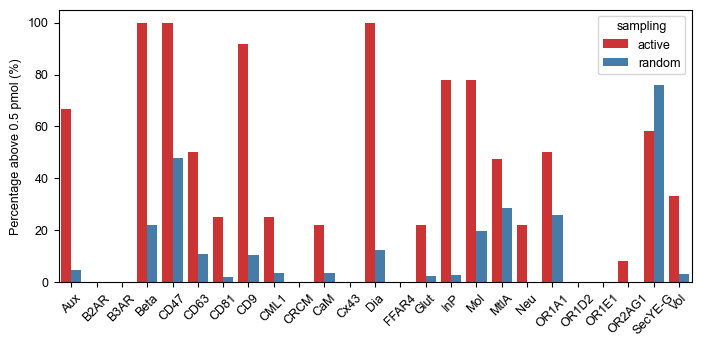

In [34]:
# Group by DNA_name and label
grouped = combined.groupby(['DNA_name', 'label'])

# Calculate the percentage of each DNA that is above 0.5 pmol_mean for each label type
percentage = grouped.apply(lambda x: (x['pmol_mean'] > 0.5).mean() * 100)
percentage = percentage.reset_index().rename(columns={0: 'percentage'})
percentage
exclude = ['AqpZ','Mito','MscL']
percentage = percentage[~percentage['DNA_name'].isin(exclude)].copy()
percentage = percentage.rename(columns={'label':'sampling'})
fig,ax = plt.subplots(figsize=[18*cm,9*cm])

sns.barplot(data=percentage,x='DNA_name',y='percentage',hue='sampling',palette='Set1',ax=ax)
plt.xticks(rotation=45, ha='center')
plt.xlabel('')
plt.ylabel('Percentage above 0.5 pmol (%)')
plt.tight_layout()


In [77]:
unstacked = percentage.set_index(['DNA_name','sampling']).unstack().reset_index().droplevel(0,axis=1).rename(columns={'':'DNA_name'})
unstacked['diff'] = (unstacked['active'] - unstacked['pred']) / unstacked['pred'] * 100
unstacked['diff'] = unstacked['diff'].fillna(0)
unstacked['diff'] = unstacked['diff'].clip(-100,5000)
unstacked
mean = unstacked['diff'].mean()
median = unstacked['diff'].median()
print(mean,median)
unstacked['diff'].value_counts()

837.9343536814232 350.0


diff
0.000       7
5000.000    2
1366.667    1
-23.328     1
94.554      1
66.234      1
294.872     1
2700.000    1
877.778     1
708.163     1
528.571     1
601.786     1
778.659     1
1128.125    1
367.857     1
108.421     1
350.000     1
1000.000    1
Name: count, dtype: int64

<Axes: xlabel='diff', ylabel='Count'>

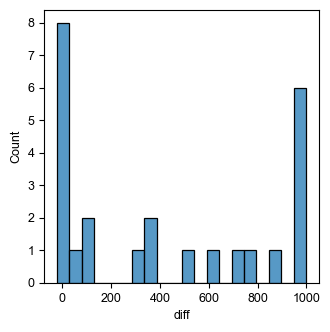

In [85]:
clipped = unstacked.copy()
clipped['diff'] = clipped['diff'].clip(-100,1000)
fig,ax = plt.subplots(figsize=[9*cm,9*cm])

sns.histplot(data=clipped,x='diff',ax=ax,bins=20)

Text(0, 0.5, 'Percentage difference in ΔYield')

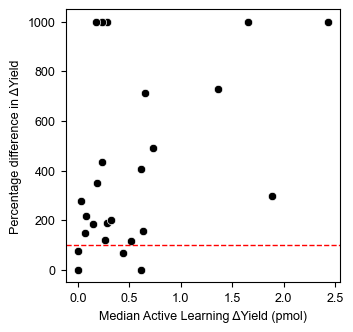

In [92]:
all_comps = []
for dna,dna_df in combined.groupby('DNA_name'):
    a = dna_df[dna_df['label'] == 'active']
    a_mean = np.median(a['pmol_mean'])
    r_mean = np.median(dna_df['pmol_mean'])
    all_comps.append([dna,a_mean,r_mean])
all_comps = pd.DataFrame(all_comps,columns=['DNA_name','active','random'])
all_comps
all_comps['diff'] = (all_comps['active'] - all_comps['random']) / abs(all_comps['random']) * 100
all_comps
fig,ax = plt.subplots(figsize=[9*cm,9*cm])
temp = all_comps.copy()
exclude = ['AqpZ','Mito','MscL']
high = temp[temp['DNA_name'].isin(exclude)].copy()
temp = temp[~temp['DNA_name'].isin(exclude)].copy()
temp['active'] = temp['active'].clip(0,10) 
temp['diff'] = temp['diff'].clip(-1,1000)
sns.scatterplot(data=temp,x='active',y='diff',ax=ax,color='black')
plt.axhline(100, color='red',linewidth=1,linestyle='--')
plt.xlabel('Median Active Learning ΔYield (pmol)')
plt.ylabel('Percentage difference in ΔYield')

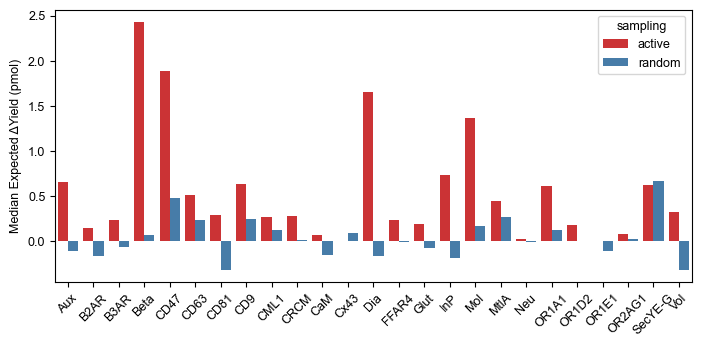

In [54]:
df = temp[['DNA_name','active','random']].set_index('DNA_name').stack().reset_index().rename(columns={'level_1':'sampling',0:'pmol'})
fig,ax = plt.subplots(figsize=[18*cm,9*cm])

sns.barplot(data=df,x='DNA_name',y='pmol',hue='sampling',palette='Set1',ax=ax)
plt.xticks(rotation=45, ha='center')
plt.xlabel('')
plt.ylabel('Median Expected ΔYield (pmol)')
plt.tight_layout()

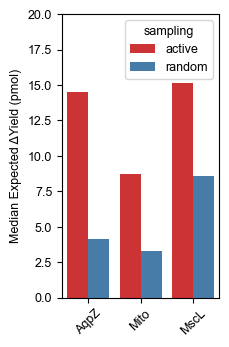

In [55]:
df = high[['DNA_name','active','random']].set_index('DNA_name').stack().reset_index().rename(columns={'level_1':'sampling',0:'pmol'})
fig,ax = plt.subplots(figsize=[6*cm,9*cm])

sns.barplot(data=df,x='DNA_name',y='pmol',hue='sampling',palette='Set1',ax=ax)
plt.xticks(rotation=45, ha='center')
plt.xlabel('')
plt.ylabel('Median Expected ΔYield (pmol)')
plt.ylim(0,20)
plt.tight_layout()

In [58]:
np.mean(all_comps['diff'])

754.08966

<Axes: xlabel='diff', ylabel='Count'>

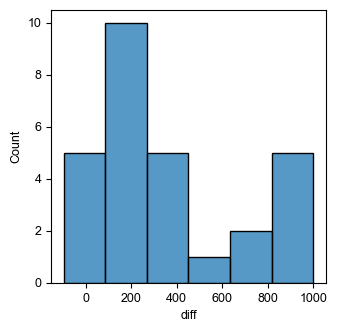

In [42]:
all_comps
clipped = all_comps.copy()
clipped['diff'] = clipped['diff'].clip(-100,1000)
fig,ax = plt.subplots(figsize=[9*cm,9*cm])

sns.histplot(data=clipped,x='diff',ax=ax)

C:\Users\conar\AppData\Local\Temp\ipykernel_9096\76132699.py:2: FutureWarning: The provided callable <function mean at 0x000001E66067D080> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  no_lipo = no_lipo[['DNA_name','pmol']].groupby('DNA_name').agg(np.mean).reset_index()


Text(0, 0.5, 'Change in yield with active learning (%)')

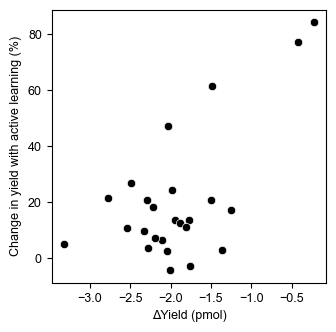

In [38]:
no_lipo = data[data['Liposome_name'] == 'no_lipo'].copy()
no_lipo = no_lipo[['DNA_name','pmol']].groupby('DNA_name').agg(np.mean).reset_index()
no_lipo = no_lipo.rename(columns={'pmol':'background'})
temp = all_comps.merge(no_lipo,left_on='DNA_name',right_on='DNA_name',how='left').copy()
temp['pmol_active'] = temp['active'] - temp['background']
temp['pmol_random'] = temp['random'] - temp['background']
temp['diff'] = (temp['pmol_active'] - temp['pmol_random']) / abs(temp['pmol_random']) * 100
exclude = ['AqpZ','Mito','MscL']
temp = temp[~temp['DNA_name'].isin(exclude)].copy()
# temp.describe()
fig,ax = plt.subplots(figsize=[9*cm,9*cm])
temp['diff'] = temp['diff'].clip(-100,1000)
sns.scatterplot(data=temp,x='pmol_active',y='diff',ax=ax, color='black')
plt.xlabel('ΔYield (pmol)')
plt.ylabel('Change in yield with active learning (%)')



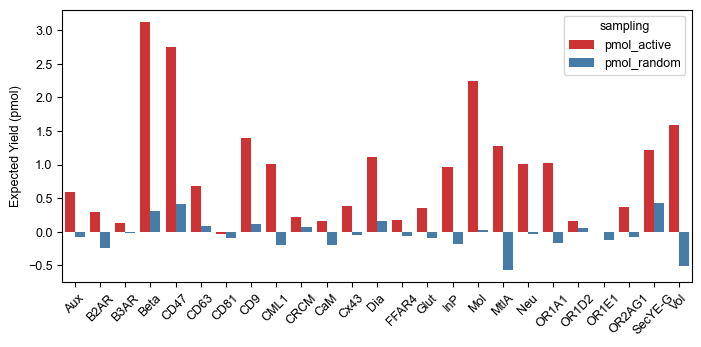

In [82]:
df = temp[['DNA_name','pmol_active','pmol_random']].set_index('DNA_name').stack().reset_index().rename(columns={'level_1':'sampling',0:'pmol'})
fig,ax = plt.subplots(figsize=[18*cm,9*cm])

sns.barplot(data=df,x='DNA_name',y='pmol',hue='sampling',palette='Set1',ax=ax)
plt.xticks(rotation=45, ha='center')
plt.xlabel('')
plt.ylabel('Expected Yield (pmol)')
plt.tight_layout()

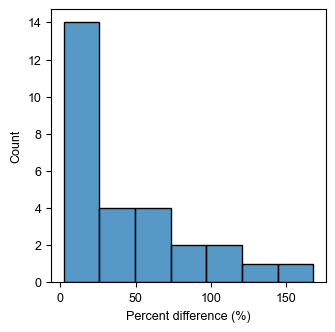

46.238182

In [47]:
fig,ax = plt.subplots(figsize=[9*cm,9*cm])
all_comps['diff'] = (all_comps['active'] - all_comps['random']) / all_comps['random'] * 100
sns.histplot(data=all_comps,x='diff',ax=ax)
plt.xlabel('Percent difference (%)')
plt.savefig(f'{fig_folder}/Backup-Active_vs_random_differences.svg',format='svg',dpi=300)

plt.show()
np.mean(all_comps['diff'])

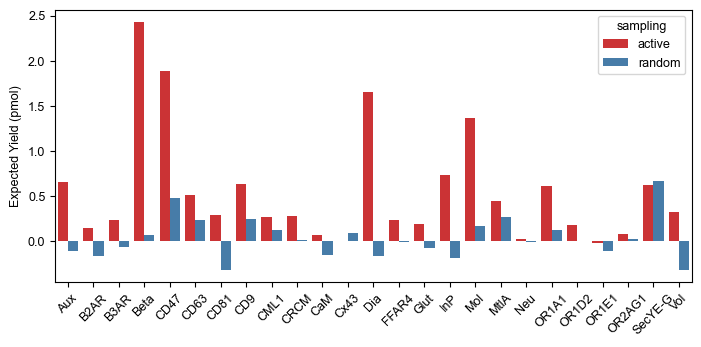

In [45]:
fig,ax = plt.subplots(figsize=[18*cm,9*cm])
temp = all_comps[['DNA_name','active','random']].set_index('DNA_name').stack().reset_index().rename(columns={'level_1':'sampling',0:'pmol'})
temp = temp[~temp['DNA_name'].isin(['AqpZ','Mito','MscL'])].copy()
sns.barplot(data=temp,x='DNA_name',y='pmol',hue='sampling',palette='Set1')
plt.xticks(rotation=45, ha='center')
plt.xlabel('')
plt.ylabel('Expected Yield (pmol)')
plt.tight_layout()
plt.savefig(f'{fig_folder}/Backup-Active_vs_random_differences_proteins.svg',format='svg',dpi=300)
plt.show()

### Use the models to predict on only the reactions that were in each model's test set which is specified in the model data

In [ ]:
test_preds = []

for i,row in model_data.iterrows():
    temp = all_features[all_features['rxn_id'].isin(list(row['test_ids']))].copy()
    temp_norm = norm_data[norm_data['rxn_id'].isin(row['test_ids'])].copy()

    preds = model_dict[row['model_id']].predict(temp_norm[row['cols']])
    temp['pred'] = preds
    temp['model_id'] = row['model_id']
    temp['ensemble'] = row['ensemble']
    test_preds.append(temp)
    
test_preds = pd.concat(test_preds).reset_index(drop=True)
test_preds

In [ ]:
joined_preds = test_preds.set_index(['ensemble','model_id']).join(model_data.set_index(['ensemble','model_id'])).reset_index()


### Convert the Z-scored data back to their pmol value using each proteins scaler

In [ ]:
test_converted = []

for [dna,label_type],dna_df in joined_preds.groupby(['DNA_name','label_type']):
    temp = dna_df.copy()
    if label_type == 'label':
        temp['original_value'] = temp['pmol']
        temp['original_label'] = scaler_dict[dna].transform(np.array(temp[['original_value']]))
        temp['converted_pred'] = scaler_dict[dna].inverse_transform(np.array(temp[['pred']]))
    elif label_type == 'label_sub':
        temp['original_value'] = temp['pmol_sub']
        temp['original_label'] = scaler_dict_sub[dna].transform(np.array(temp[['original_value']]))
        temp['converted_pred'] = scaler_dict_sub[dna].inverse_transform(np.array(temp[['pred']]))
    else:
        print('Unknown label type:',label_type)
        continue
    test_converted.append(temp)
    
test_converted = pd.concat(test_converted).reset_index(drop=True)
test_converted

### Evaluate model performance
* Looks at each ensemble separately to compare their performance
* Calculates R2 value from a linear regression based on:
    * each model prediction on each replicate reaction
    * the ensemble prediction and mean of replicates


In [ ]:
group_cols = ['DNA_name','Mg', 'SecYE', 'K', 'PEG','lipid']

obs_name = 'original_label'
pred_name = 'pred'

for ensemble,ensemble_df in test_converted[test_converted['ensemble'] == 'dna_encoded'].groupby(['ensemble','label_type']):
    mae_train = median_absolute_error(ensemble_df[obs_name], ensemble_df[pred_name])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ensemble_df[pred_name], ensemble_df[obs_name])
    
    t = ensemble_df.groupby(group_cols)[[obs_name,pred_name]].agg(np.mean)
    slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = scipy.stats.linregress(t[pred_name], t[obs_name])
    print(f'R_value for all:{r_value}')
    scores = {
        "MAE on data set": f"{mae_train:.2f}",
        "R2 of fit": f"{r_value_mean:.2f}",
    }

    fig,ax = plt.subplots(figsize=[6*cm,6*cm])
    display = PredictionErrorDisplay.from_predictions(
        ensemble_df[obs_name], ensemble_df[pred_name], kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5,'s':5}
    )
    
    sns.scatterplot(data=t.sample(300),x=pred_name,y=obs_name,color='black',alpha=0.5,s=10)
    
    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper right")
    plt.xticks([-2,0,2,4])
    plt.yticks([-2,0,2,4])
    plt.tight_layout()
    plt.xlabel('Predicted Z score')
    plt.ylabel('Observed Z score')

    plt.savefig(f'{fig_folder}/Fig3B-pred_vs_actual-Prot_ids.svg',format='svg',dpi=300)
    plt.show()

ensemble_df[['ensemble', 'model_id', 'DNA_name', 'rxn_id', 'lipid', 'Mg', 'SecYE',
       'K', 'PEG', 'pmol', 'pmol_sub','pred','original_value', 'original_label', 'converted_pred']].set_index('ensemble').to_excel(f'{data_folder}/Fig3B-prot_id_predictions.xlsx')

In [ ]:
plt.rcParams['font.size'] = 12

group_cols = ['DNA_name','Mg', 'SecYE', 'K', 'PEG','lipid']

obs_name = 'original_label'
pred_name = 'pred'

for ensemble,ensemble_df in test_converted[test_converted['ensemble'] == 'no_prot_features'].groupby(['ensemble','label_type']):
    mae_train = median_absolute_error(ensemble_df[obs_name], ensemble_df[pred_name])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ensemble_df[pred_name], ensemble_df[obs_name])
    
    t = ensemble_df.groupby(group_cols)[[obs_name,pred_name]].agg(np.mean)
    slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = scipy.stats.linregress(t[pred_name], t[obs_name])
    
    scores = {
        "MAE on data set": f"{mae_train:.2f}",
        "R2 of fit": f"{r_value_mean:.2f}",
    }

    fig,ax = plt.subplots(figsize=[9*cm,9*cm])
    display = PredictionErrorDisplay.from_predictions(
        ensemble_df[obs_name], ensemble_df[pred_name], kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5,'s':20}
    )
    
    sns.scatterplot(data=t.sample(300),x=pred_name,y=obs_name,color='black',alpha=0.5,s=30)
    
    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper right")
    plt.xticks([-2,0,2,4])
    plt.yticks([-2,0,2,4])
    plt.tight_layout()
    plt.xlabel('Predicted Z score')
    plt.ylabel('Observed Z score')

    plt.savefig(f'{fig_folder}/Supp_fig-pred_vs_actual-rxn_features.svg',format='svg',dpi=300)
    plt.show()
    
ensemble_df[['ensemble', 'model_id', 'DNA_name', 'rxn_id', 'lipid', 'Mg', 'SecYE',
       'K', 'PEG', 'pmol', 'pmol_sub','pred','original_value', 'original_label', 'converted_pred']].set_index('ensemble').to_excel(f'{data_folder}/Supp_fig-rxn_feature_predictions.xlsx')
plt.rcParams['font.size'] = 7


### Investigate the ensemble performance on individual proteins

In [ ]:
group_cols = ['DNA_name','Mg', 'SecYE', 'K', 'PEG','lipid']

obs_name = 'original_label'
pred_name = 'pred'

all_r_vals = []

temp = test_converted[test_converted['ensemble'] == 'dna_encoded']
for dna,dna_df in temp.groupby('DNA_name'):
    mae_train = median_absolute_error(dna_df[obs_name], dna_df[pred_name])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dna_df[pred_name], dna_df[obs_name])
    
    t = dna_df.groupby(group_cols)[[obs_name,pred_name]].agg(np.mean)
    slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = scipy.stats.linregress(t[pred_name], t[obs_name])
    
    def abline(slope, intercept,ax,color='red'):
        """Plot a line from slope and intercept"""
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = intercept + slope * x_vals
        ax.plot(x_vals, y_vals, '--',color=color)

    scores = {
        "MAE on data set": f"{mae_train:.2f} pmol",
        "R2 of fit": f"{r_value:.2f}",
        "R2 of mean fit": f"{r_value_mean:.2f}",
    }

    _, ax = plt.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
        dna_df[obs_name], dna_df[pred_name], kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
    )
    ax.set_title(f"{dna}: Predicted versus observed yields")
    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")
    plt.tight_layout()
    # plt.plot([-5,25],[-5,25],color='black',ls='--')
    plt.axvline(0,color='grey')
    plt.axhline(0,color='grey')
    abline(slope, intercept,ax)
    upper = round(np.max(dna_df[obs_name])*1.25)+1
    lower = round(np.min(dna_df[obs_name])*0.75)-1
    # upper = 10
    # lower = 0
    
    sns.scatterplot(data=t,x=pred_name,y=obs_name,color='black')
    abline(slope_mean, intercept_mean,ax,color='grey')
    plt.xlim([lower,upper])
    plt.ylim([lower,upper])
    plt.axvline(1)
    plt.axhline(1)
    
    plt.show()
    
    all_r_vals.append([dna,r_value,r_value_mean])
    
# all_r_vals = pd.concat(all_r_vals)
# all_r_vals

# Compare the active learning reactions to the screening data

## Prepare data for analysis

In [ ]:
data = pd.read_pickle('../General_data/screen_active_data.pkl')
data

In [ ]:
sub_df = []

for rxn_id,rxn_df in data.groupby('rxn_id'):
    lipo = rxn_df[rxn_df['Liposome_conc'] != 0].copy()
    nolipo = rxn_df[rxn_df['Liposome_conc'] == 0].copy()
    nolipo_mean = np.mean(nolipo['pmol'])
    if len(nolipo) == 0:
        print(rxn_id)
        continue
    lipo['pmol_sub'] = lipo['pmol'] - nolipo_mean
    nolipo['pmol_sub'] = nolipo['pmol'] - nolipo_mean
    
    sub_df.append(lipo)
    sub_df.append(nolipo)
    
sub_df = pd.concat(sub_df)
sub_df

## Calculate the difference in active learning and screening reaction populations for each protein
* Calculates the significance of the change to active learning using a t-test
* Defines significance as a p-value less than 0.05
* Identifies 21 proteins as significant

In [ ]:
lipo_all = sub_df[sub_df['Liposome_name'] != 'no_lipo'].copy()
means = lipo_all.groupby('rxn_id')[['pmol','pmol_sub']].agg(np.mean)
lipo_all = means.join(lipo_all[['label','rxn_id','DNA_name','Mg','K','PEG','SecYE','Liposome_name','pmol','pmol_sub']].set_index('rxn_id'),lsuffix='_mean').drop_duplicates()

p_vals = []
for dna,dna_df in lipo_all.groupby('DNA_name'):
    a = dna_df[dna_df['label'] == 'active']
    s = dna_df[dna_df['label'] == 'screen']
    
    pval = -np.log(ttest_ind(a['pmol_sub'],s['pmol_sub'])[1])

    a_mean = a['pmol_sub'].mean()
    s_mean = s['pmol_sub'].mean()
    
    diff = a_mean - s_mean

    p_vals.append([dna,diff,pval])
    
p_vals = pd.DataFrame(p_vals,columns=['DNA_name','diff','pval'])
p_vals['pval'] = p_vals['pval'].clip(0,50)

In [ ]:
x_thresh = 0.1
y_thresh = -np.log(0.05)

fig,ax = plt.subplots(figsize=[6*cm,6*cm])

sns.scatterplot(data=p_vals,x='diff',y='pval',alpha=0.4,color='black')
sns.scatterplot(data=p_vals[(p_vals['diff'] > x_thresh) & (p_vals['pval'] > y_thresh)],x='diff',y='pval',alpha=0.4,color='blue')

plt.axvline(x_thresh,color='black',ls='--')
plt.axhline(y_thresh,color='black',ls='--')

plt.show()

In [ ]:
sns.displot(data=p_vals,x='pval',bins=50)
plt.axvline(-np.log(0.05),color='k',ls='--')
plt.show()

In [ ]:
significant = p_vals[p_vals['pval'] > -np.log(0.05)]['DNA_name'].tolist()
significant = [x for x in significant if x != 'Cx43']
len(significant)

In [ ]:
high = ['AqpZ','MscL','Mito']

def assign_group(dna):
    if dna in high:
        return 'high'
    elif dna in significant:
        return 'significant'
    else:
        return 'insignificant'
    
lipo_all['group'] = lipo_all['DNA_name'].apply(assign_group)
lipo_all

### Fig 3C - Plot the different reactions for both the screening and active learning reactions
* The average of each reaction composition is plotted instead of all replicates to make it possible to include all reactions conditions

In [ ]:
lipo_means = lipo_all.reset_index().drop_duplicates(subset='rxn_id').drop(columns=['pmol','pmol_sub']).rename(columns={'pmol_mean':'pmol','pmol_sub_mean':'pmol_sub'})

medians = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg(np.median)

medians = medians.unstack()
medians.columns = ['active','screen']
medians['diff'] = medians['active'] - medians['screen']
medians['percent'] = (medians['active'] - medians['screen']) / medians['screen']
medians['label'] = 'Median'

means = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg(np.mean)
means = means.unstack()
means.columns = ['active','screen']
means['diff'] = means['active'] - means['screen']
means['percent'] = (means['active'] - means['screen']) / means['screen']
means['label'] = 'Mean'

maxs = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg(np.max)
maxs = maxs.unstack()
maxs.columns = ['active','screen']
maxs['diff'] = maxs['active'] - maxs['screen']
maxs['percent'] = (maxs['active'] - maxs['screen']) / maxs['screen']
maxs['label'] = 'Max'

mins = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg(np.min)
mins = mins.unstack()
mins.columns = ['active','screen']
mins['diff'] = mins['active'] - mins['screen']
mins['percent'] = (mins['active'] - mins['screen']) / mins['screen']
mins['label'] = 'Min'

stdevs = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg(np.std)
stdevs = stdevs.unstack()
stdevs.columns = ['active','screen']
stdevs['diff'] = stdevs['active'] - stdevs['screen']
stdevs['percent'] = (stdevs['active'] - stdevs['screen']) / stdevs['screen']
stdevs['label'] = 'Stdev'

calcs = pd.concat([medians,means,maxs,mins]).reset_index()
calcs['percent'] = calcs['percent'].clip(-2,2)

meta = pd.read_excel('../General_data/protein_metadata.xlsx')
calcs = calcs.set_index('DNA_name').join(meta.set_index('DNA_name')).reset_index()

high = ['AqpZ','MscL','Mito']
fig,ax = plt.subplots(figsize=[6*cm,6*cm])

current = calcs[(~calcs['DNA_name'].isin(high))]

sns.swarmplot(data=current,x='label',y='diff',ax=ax,s=3,palette='viridis')
plt.axhline(0,c='k',ls='--',lw=0.75)
plt.xlabel('Statistic')
plt.ylabel('Difference (pmol)')
# plt.savefig(f'{fig_folder}/all_stats_comparison.svg',format='svg',dpi=300)
plt.show()


In [ ]:
t = lipo_means[lipo_means['group'] == 'high'].groupby(['DNA_name','label'])[['pmol_sub']].agg(np.median).reset_index()
t = t[t['label'] == 'active'].sort_values('pmol_sub')
high_dna_order = t['DNA_name'].tolist()

PROPS = {
    'boxprops':{'edgecolor':'black','facecolor':'#e0e0e0'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops':{'color':'none'}
}

current = lipo_means[lipo_means['DNA_name'].isin(high)]


fig,ax = plt.subplots(figsize=[3*cm,6*cm])

sns.stripplot(data=current,x='DNA_name',y='pmol_sub',hue='label',hue_order=['screen','active'],ax=ax,palette='Set1',order=high_dna_order[:],\
              dodge=True,edgecolor="black",linewidth=0.3,alpha=0.8,s=2,jitter=0.2)

sns.boxplot(data=current,x='DNA_name',y='pmol_sub',hue='label',ax=ax,\
            hue_order=['screen','active'],palette='Set1',order=high_dna_order[:],saturation=1,linewidth=0.75,**PROPS,fliersize=2,notch=False)

plt.axhline(0,c='k',ls='--',lw=0.5)
ax.get_legend().remove()
plt.xticks(rotation=45, ha='center')

plt.savefig(f'{fig_folder}/Fig3C-active_boxplots_high_w_heat.svg',format='svg',dpi=300)

plt.show()
current.to_excel(f'{data_folder}/Fig3C-high_averages.xlsx')

In [ ]:
comps = calcs[['DNA_name','label','diff']].set_index(['DNA_name','label']).unstack()
comps.columns = comps.columns.droplevel()
comps = comps.T

comps = comps[high_dna_order]
fig,ax = plt.subplots(figsize=[3*cm,3*cm])

ax = sns.heatmap(comps,cmap='coolwarm_r',ax=ax,center=0,vmin=-1,vmax=1,linewidth=.5)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('')
plt.ylabel('')
plt.savefig(f'{fig_folder}/Fig3C-changes-high-heatmap.svg',format='svg',dpi=300)

plt.show()

comps.to_excel(f'{data_folder}/Fig3C-High_active_heatmap.xlsx')

In [ ]:
t = lipo_means[lipo_means['group'] == 'significant'].groupby(['DNA_name','label'])[['pmol_sub']].agg(np.median).reset_index()

t = t[t['label'] == 'active'].sort_values('pmol_sub')
sig_dna_order = t['DNA_name'].tolist()

fig,ax = plt.subplots(figsize=[16*cm,6*cm])
PROPS = {
    'boxprops':{'edgecolor':'black','facecolor':'#e0e0e0'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops':{'color':'none'}
}
current = lipo_means[lipo_means['group'] == 'significant']

sns.stripplot(data=current,x='DNA_name',y='pmol_sub',hue='label',hue_order=['screen','active'],ax=ax,palette='Set1',order=sig_dna_order[:],\
              dodge=True,edgecolor="black",linewidth=0.3,alpha=0.8,s=2,jitter=0.2)

sns.boxplot(data=current,x='DNA_name',y='pmol_sub',hue='label',ax=ax,\
            hue_order=['screen','active'],palette='Set1',order=sig_dna_order[:],saturation=1,linewidth=0.75,**PROPS,fliersize=2,notch=False)

plt.axhline(0,c='k',ls='--',lw=0.5)
ax.get_legend().remove()
plt.xticks(rotation=45, ha='center')
plt.xlabel('')

plt.savefig(f'{fig_folder}/Fig_3C-active_boxplots_sign-w_heat.svg',format='svg',dpi=300)
plt.show()
current.to_excel(f'{data_folder}/Fig3C-significant_averages.xlsx')

In [ ]:
comps = calcs[['DNA_name','label','diff']].set_index(['DNA_name','label']).unstack()
comps.columns = comps.columns.droplevel()
comps = comps.T
comps = comps[sig_dna_order]
fig,ax = plt.subplots(figsize=[18*cm,4*cm])

ax = sns.heatmap(comps,cmap='coolwarm_r',ax=ax,center=0,vmin=-1,vmax=1,linewidth=.5)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('')
plt.ylabel('')
plt.savefig(f'{fig_folder}/Fig3C-changes-heatmap.svg',format='svg',dpi=300)

plt.show()
comps.to_excel(f'{data_folder}/Fig3C-Significant_active_heatmap.xlsx')

In [ ]:
t = lipo_means[lipo_means['group'] == 'insignificant'].groupby(['DNA_name','label'])[['pmol_sub']].agg(np.median).reset_index()
t = t[t['label'] == 'active'].sort_values('pmol_sub')
insig_dna_order = t['DNA_name'].tolist()

fig,ax = plt.subplots(figsize=[8*cm,6*cm])

current = lipo_means[lipo_means['group'] == 'insignificant']

sns.stripplot(data=current,x='DNA_name',y='pmol_sub',hue='label',hue_order=['screen','active'],ax=ax,palette='Set1',order=insig_dna_order[:],\
              dodge=True,edgecolor="black",linewidth=0.3,alpha=0.8,s=2,jitter=0.2)

sns.boxplot(data=current,x='DNA_name',y='pmol_sub',hue='label',ax=ax,\
            hue_order=['screen','active'],palette='Set1',order=insig_dna_order[:],saturation=1,linewidth=0.75,**PROPS,fliersize=2,notch=False)

plt.axhline(0,c='k',ls='--',lw=0.5)
ax.get_legend().remove()
plt.xticks(rotation=45, ha='center')

plt.axhline(0,c='k',ls='--')
plt.savefig(f'{fig_folder}/Supp_fig-active_boxplots_insignificant.svg',format='svg',dpi=300)

plt.show()
current.to_excel(f'{data_folder}/Supp_Fig-Insignificant_averages.xlsx')

In [ ]:
comps = calcs[['DNA_name','label','diff']].set_index(['DNA_name','label']).unstack()
comps.columns = comps.columns.droplevel()
comps = comps.T
comps = comps[insig_dna_order]
fig,ax = plt.subplots(figsize=[6*cm,3*cm])

ax = sns.heatmap(comps,cmap='coolwarm_r',ax=ax,center=0,vmin=-1,vmax=1,linewidth=.5)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('')
plt.ylabel('')
plt.savefig(f'{fig_folder}/Supp_fig-changes-insign-heatmap.svg',format='svg',dpi=300)

plt.show()

comps.to_excel(f'{data_folder}/Supp_Fig-insignificant_active_heatmap.xlsx')

### Fig 3D - Calculate trajectories between the standard and best performing reaction composition
* Extract the reaction ids for the standard reactions and the top performing for each protein
* Normalize the reaction component concentrations and the resulting yields
    * A min-max scaler is used on the yield so that it always sets the highest value to one and then the standard reaction is some fraction of it
* Calculate the Euclidean distance between each reaction component concentration and the different yields

In [ ]:
standard = {
    'Mg':[12,14],
    'K':[85],
    'PEG':[2],
    'Liposome_name':['DOPC'],
    'SecYE':[0],
}

standard_df = lipo_means.copy()
for key in standard.keys():
    standard_df = standard_df[standard_df[key].isin(standard[key])]
dup = standard_df[(standard_df['DNA_name'].isin(['AqpZ','Glut','CD47','MscL']))]
non_dup = standard_df[(~standard_df['DNA_name'].isin(['AqpZ','Glut','CD47','MscL']))]
dup = dup[dup['Mg'] == 14].copy()
standard_df = pd.concat([non_dup,dup])
standard_df = standard_df[['rxn_id','DNA_name','Mg','K','PEG','Liposome_name','SecYE','pmol_sub']]

temp_df = []
temp_array = []
for dna,dna_df in standard_df.groupby('DNA_name'):
    if len(dna_df) == 1:
        temp_df.append(dna_df)
    else:
        mean = np.mean(dna_df['pmol_sub'])
        t = dna_df.copy()
        t['pmol_sub'] = mean
        t = t.iloc[0]
        temp_array.append(t)
standard_df = pd.concat(temp_df)
temp_array = pd.DataFrame(temp_array)

standard_df = pd.concat([standard_df,temp_array])
len(standard_df['DNA_name'].unique())
standard_ids = standard_df[['rxn_id','DNA_name']]
standard_df

In [ ]:
best = []

for dna,dna_df in lipo_means.groupby('DNA_name'):
    best.append(dna_df.sort_values('pmol_sub',ascending=False).iloc[0])
best = pd.DataFrame(best)
best = best[['rxn_id','DNA_name','Mg','K','PEG','Liposome_name','SecYE','pmol_sub']]
best_ids = best[['rxn_id','DNA_name']]

In [ ]:
best_ids

In [ ]:
all_features = lipo_means.copy()

lipo_dict = {'DOPC':18,'DPPC':16,'DMPC':14,'no_lipo':0}
all_features['lipid'] = all_features['Liposome_name'].apply(lambda x: lipo_dict[x])
all_features

data_bounded = all_features[['Mg', 'SecYE', 'K', 'PEG','lipid']]
X_bounded = np.array(data_bounded)
MMscalerX = MinMaxScaler()

X_bounded = MMscalerX.fit_transform(X_bounded)
data_bounded = pd.DataFrame(X_bounded,columns=data_bounded.columns)
data_bounded['rxn_id'] = all_features['rxn_id'].tolist()
data_bounded = data_bounded.set_index('rxn_id')
data_bounded

In [ ]:
y_col = 'pmol_sub'

transformed = []
scaler_dict = {}

all_features = lipo_means.copy()
all_features
for dna, dna_df in all_features.groupby('DNA_name'):
    temp = dna_df.copy()
    y_scaled = np.array(temp[[y_col]])
    scalerY = MinMaxScaler()
    y_scaled = scalerY.fit_transform(y_scaled)
    temp['pmol_sub'] = y_scaled
    transformed.append(temp)
    scaler_dict.update({dna:scalerY})
transformed = pd.concat(transformed)
transformed = transformed[['rxn_id',y_col]].set_index('rxn_id')
transformed

In [ ]:
norm_data = data_bounded.join(transformed).reset_index()
norm_data

In [ ]:
def calc_trajectory(row):
    return np.sqrt(((row['value_final'] - row['value_init'])**2) + ((row['pmol_sub_final'] - row['pmol_sub_init'])**2))


final = best_ids.set_index('rxn_id').join(norm_data.set_index('rxn_id')).reset_index().drop(columns=['rxn_id'])
final = final.set_index(['DNA_name','pmol_sub']).stack().reset_index().rename(columns={'level_2':'variable',0:'value'})
final
initial = standard_ids.set_index('rxn_id').join(norm_data.set_index('rxn_id')).reset_index().drop(columns=['rxn_id'])
initial = initial.set_index(['DNA_name','pmol_sub']).stack().reset_index().rename(columns={'level_2':'variable',0:'value'})

comparison = initial.set_index(['DNA_name','variable']).join(final.set_index(['DNA_name','variable']),lsuffix='_init',rsuffix='_final').reset_index()
comparison['distance'] = comparison.apply(calc_trajectory,axis=1)
comparison

In [ ]:
heat_comp = comparison[['DNA_name','variable','distance']].set_index(['DNA_name','variable']).unstack().T.reset_index()
heat_comp = heat_comp.drop(columns=['level_0']).set_index('variable')

heat_comp = heat_comp[sig_dna_order]

fig,ax = plt.subplots(figsize=[18*cm,3*cm])
ax = sns.heatmap(heat_comp,cmap='viridis',ax=ax,linewidth=.5,vmin=0,vmax=1.33)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('')
plt.ylabel('')
plt.savefig(f'{fig_folder}/Fig3D-trajectory_heatmap.svg',format='svg',dpi=300)

plt.show()
heat_comp.to_excel(f'{data_folder}/Fig3D-significant_trajectory.xlsx')

In [ ]:
heat_comp = comparison[['DNA_name','variable','distance']].set_index(['DNA_name','variable']).unstack().T.reset_index()
heat_comp = heat_comp.drop(columns=['level_0']).set_index('variable')

heat_comp = heat_comp[high_dna_order]

fig,ax = plt.subplots(figsize=[3*cm,3*cm])
ax = sns.heatmap(heat_comp,cmap='viridis',ax=ax,linewidth=.5,vmin=0,vmax=1.33)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('')
plt.ylabel('')
plt.savefig(f'{fig_folder}/Fig3D-trajectory_heatmap_high.svg',format='svg',dpi=300)

plt.show()
heat_comp.to_excel(f'{data_folder}/Fig3D-high_trajectory.xlsx')

In [ ]:
heat_comp = comparison[['DNA_name','variable','distance']].set_index(['DNA_name','variable']).unstack().T.reset_index()
heat_comp = heat_comp.drop(columns=['level_0']).set_index('variable')

heat_comp = heat_comp[insig_dna_order]

fig,ax = plt.subplots(figsize=[6*cm,3*cm])
ax = sns.heatmap(heat_comp,cmap='viridis',ax=ax,linewidth=.5,vmin=0,vmax=1.33)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('')
plt.ylabel('')
plt.savefig(f'{fig_folder}/Supp_fig-trajectory_heatmap_insig.svg',format='svg',dpi=300)

plt.show()
heat_comp.to_excel(f'{data_folder}/Supp_Fig-insignificant_trajectory.xlsx')

In [ ]:
fig,ax = plt.subplots(figsize=[3*cm,3*cm])

t = comparison.copy()
t = t[(t['DNA_name'] == 'Dia') & (t['variable'] == 'K')].iloc[0]
pmol = [t['pmol_sub_init'],t['pmol_sub_final']]
conc = [t['value_init'],t['value_final']]

ax.plot(conc,pmol,color='grey')
ax.scatter(conc,pmol,color='k')
plt.xlim([-0.25,1.25])
plt.ylim([-0.25,1.25])
plt.savefig(f'{fig_folder}/Fig3D-trajectory_explanation.svg',format='svg',dpi=300)

plt.show()

### Comparisons

In [ ]:
heat_comp = comparison[['DNA_name','variable','distance']].set_index(['DNA_name','variable']).unstack().T.reset_index()
heat_comp = heat_comp.drop(columns=['level_0']).set_index('variable')

heat_comp.mean(axis=1)

In [ ]:
sns.swarmplot(data=comparison[['DNA_name','variable','distance']],x='variable',y='distance')
plt.show()